In [1]:
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
import bayespy 

import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import ks_2samp

# pd.set_option('display.max_columns', None)

from utils import *

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

#%load_ext watermark
#%watermark -dtmvgp numpy,scipy,matplotlib,pandas,seaborn,pymc3,theano,arviz

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data_netw = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_daypart.csv').drop(columns= ['TOTAL_CONV'])
data_dig = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_digital.csv')

# data_netw = pd.read_csv('../data/tv_network.csv').drop(columns= ['TOTAL_CONV'])
# data_dig = pd.read_csv('../data/tv_digital.csv')

# combining 2 dfs
data = pd.concat([data_netw, data_dig], axis= 1)

# Filter the rows where sum of the values = 0
# data = data[data.iloc[:,:-1].sum(axis=1)!=0]

In [3]:
data.head()

,TV_PRIMEACCESS,TV_LATEFRINGE,TV_PRIME,TV_DAYTIME,TV_EARLYMORNING,TV_EARLYFRINGE,TV_OVERNIGHT,DIGITAL_HX,DIGITAL_TREMOR,TOTAL_CONV
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.39,0.0,16
1,13.0,11.0,34.0,23.0,0.0,43.0,0.0,1.00,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.00,0.0,0
3,0.0,1.0,0.0,3.0,0.0,1.0,0.0,0.00,0.0,0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0


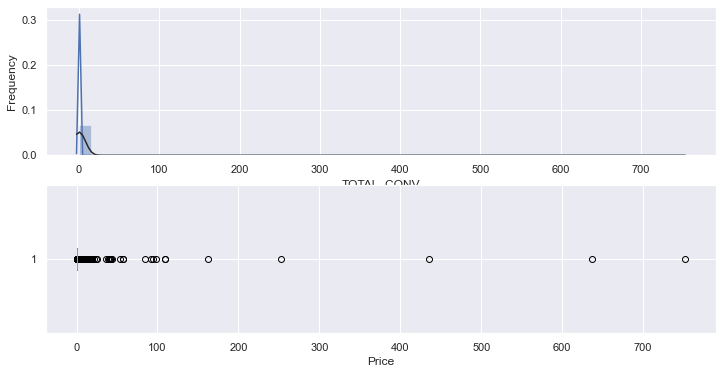

In [4]:
target_distribution(data.TOTAL_CONV)

In [5]:
# data = data[data.TOTAL_CONV != 0]
data = data[(data.TOTAL_CONV<100)] # & (data.TOTAL_CONV!=0)

In [6]:
x = data[[col for col in data.columns if col != 'TOTAL_CONV']].values
y = data.TOTAL_CONV.values

### ZeroInflatedNegativeBinomial for Likelihood Function

In [7]:
with pm.Model() as model_zero_nb:

        # Intercept
        alpha = pm.Normal('alpha', mu=y.mean(), sd=10)

        # Slope
        beta = pm.HalfFlat('beta', shape = len(data.columns[:-1]))

        # Error term
        eps = pm.Gamma('eps', 1, 0.5)
        
        psi = pm.Beta('psi', 1, 1)

        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
        
        conv = pm.ZeroInflatedNegativeBinomial('conv', 
                                              mu = mu,
                                              psi = psi,
                                              alpha = eps,
                                              observed = y)
        
        trace_zero_nb = pm.sample(chains = 4, target_accept = 0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [psi, eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4537 seconds.
The number of effective samples is smaller than 25% for some parameters.


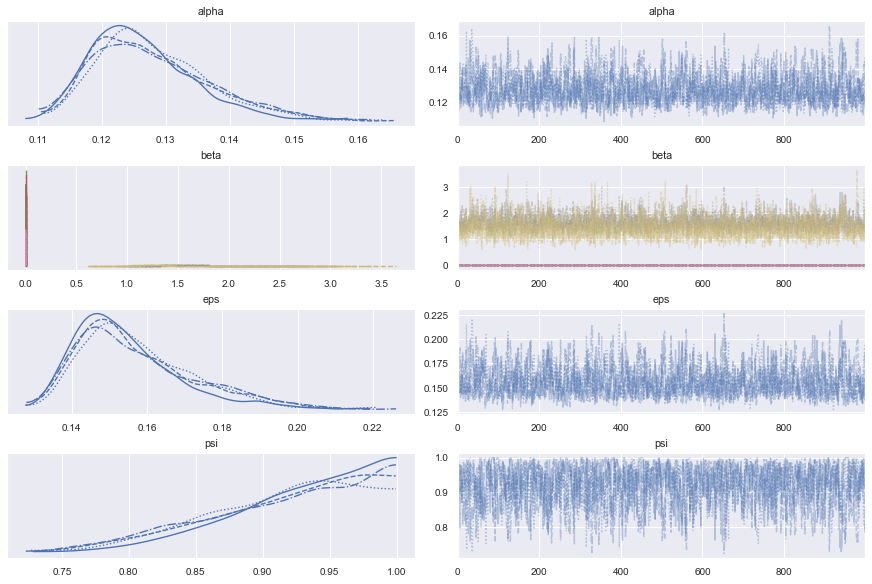

In [8]:
az.plot_trace(trace_zero_nb)
plt.show()

posterior predictive variable conv's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


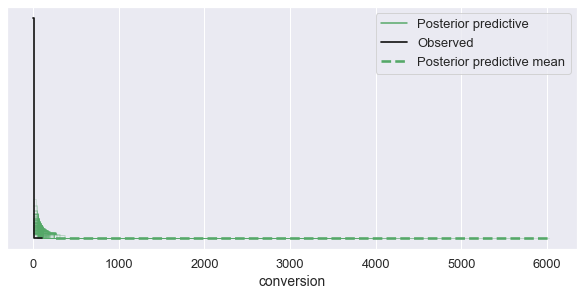

R2 for Model is : 0.961


In [9]:
predictions_zero_nb = ppc_check(model=model_zero_nb, 
                            data = data, 
                            trace= trace_zero_nb, 
                            predictions= True)

In [10]:
az.summary(trace_zero_nb, var_names='beta').set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TV_PRIMEACCESS,0.000,0.000,0.000,0.001,0.000,0.000,2676.0,1197.0,1.0
TV_LATEFRINGE,0.000,0.000,0.000,0.000,0.000,0.000,2792.0,1871.0,1.0
TV_PRIME,0.000,0.000,0.000,0.000,0.000,0.000,2639.0,1580.0,1.0
TV_DAYTIME,0.000,0.000,0.000,0.000,0.000,0.000,2067.0,1468.0,1.0
TV_EARLYMORNING,0.000,0.000,0.000,0.000,0.000,0.000,2467.0,1480.0,1.0
TV_EARLYFRINGE,0.000,0.000,0.000,0.000,0.000,0.000,2320.0,1190.0,1.0
TV_OVERNIGHT,0.000,0.000,0.000,0.000,0.000,0.000,2448.0,1587.0,1.0
DIGITAL_HX,1.645,0.285,1.178,2.196,0.007,0.005,1861.0,2239.0,1.0
DIGITAL_TREMOR,1.420,0.387,0.803,2.166,0.010,0.007,1603.0,2124.0,1.0


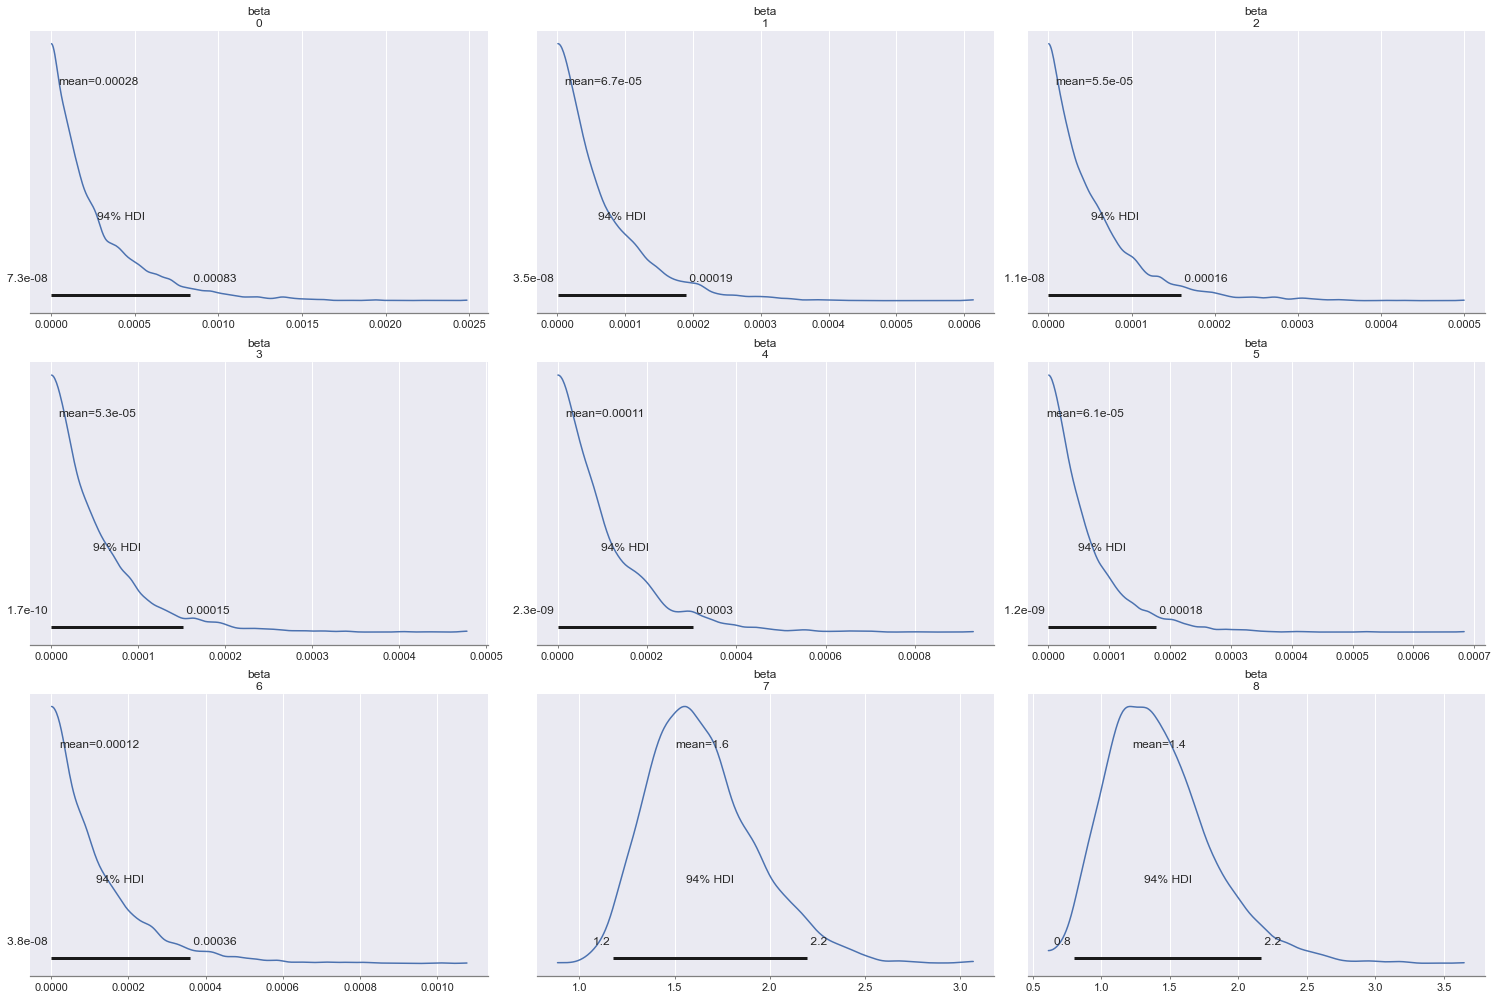

In [11]:
az.plot_posterior(trace_zero_nb, 
                  var_names=["beta"], )
plt.show()